In [1]:
stevens = read.csv('data/stevens.csv')

In [2]:
str(stevens)

'data.frame':	566 obs. of  9 variables:
 $ Docket    : Factor w/ 566 levels "00-1011","00-1045",..: 63 69 70 145 97 181 242 289 334 436 ...
 $ Term      : int  1994 1994 1994 1994 1995 1995 1996 1997 1997 1999 ...
 $ Circuit   : Factor w/ 13 levels "10th","11th",..: 4 11 7 3 9 11 13 11 12 2 ...
 $ Issue     : Factor w/ 11 levels "Attorneys","CivilRights",..: 5 5 5 5 9 5 5 5 5 3 ...
 $ Petitioner: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Respondent: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ LowerCourt: Factor w/ 2 levels "conser","liberal": 2 2 2 1 1 1 1 1 1 1 ...
 $ Unconst   : int  0 0 0 0 0 1 0 1 0 0 ...
 $ Reverse   : int  1 1 1 1 1 0 1 1 1 1 ...


In [3]:
library(caTools)

In [4]:
set.seed(3000)

In [5]:
spl = sample.split(stevens$Reverse, SplitRatio = 0.7)

In [6]:
Train = subset(stevens, spl == TRUE)

In [7]:
Test = subset(stevens, spl == FALSE)

In [8]:
# install.packages('rpart')
# install.pacakges('rpart.plot')

ERROR: Error in contrib.url(repos, "source"): trying to use CRAN without setting a mirror


In [10]:
library(rpart)
library(rpart.plot)

In [11]:
StevensTree = rpart(Reverse ~Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst,
                   data=Train, method='class', minbucket=25) # method='class' means classificaiton tree

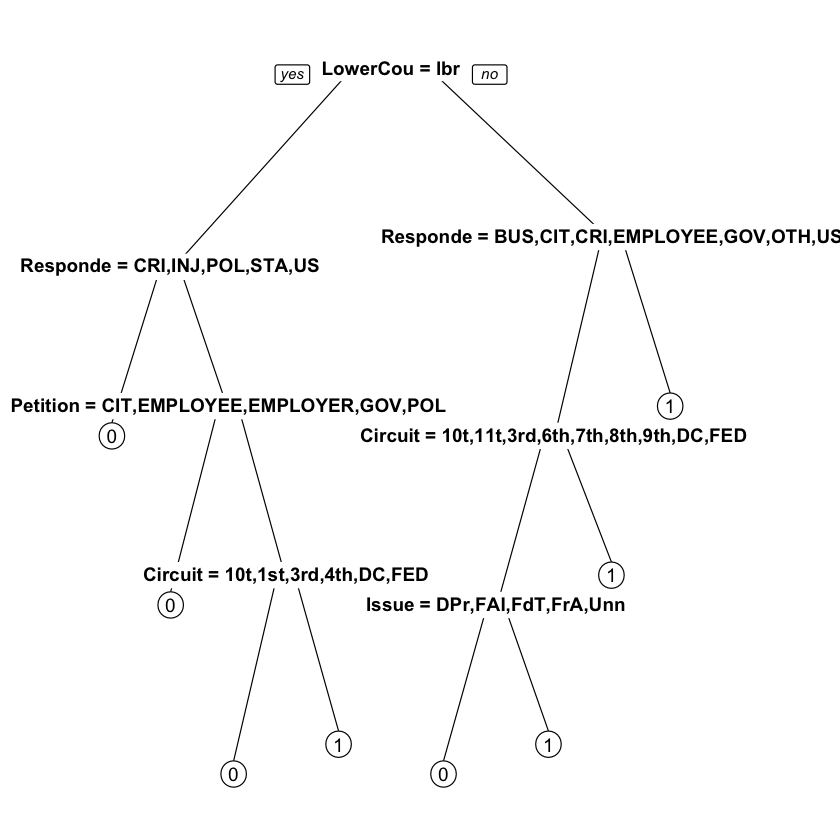

In [12]:
prp(StevensTree)

In [13]:
PredictCART = predict(StevensTree, newdata = Test, type='class')

In [14]:
table(Test$Reverse, PredictCART)

   PredictCART
     0  1
  0 41 36
  1 22 71

In [15]:
# ACC:
(41+71) / (41+36+22+71)

[1] 0.6588235

In [16]:
library(ROCR)

Loading required package: gplots
Warning message:
: package ‘gplots’ was built under R version 3.2.4
Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [17]:
PredictROC = predict(StevensTree, newdata = Test)

In [19]:
head(PredictROC)

,0,1
1,0.3035714,0.6964286
3,0.3035714,0.6964286
4,0.4,0.6
6,0.4,0.6
8,0.4,0.6
21,0.3035714,0.6964286


## plot ROC

In [21]:
pred = prediction(PredictROC[, 2], Test$Reverse)


In [24]:
perf = performance(pred, 'tpr', 'fpr')

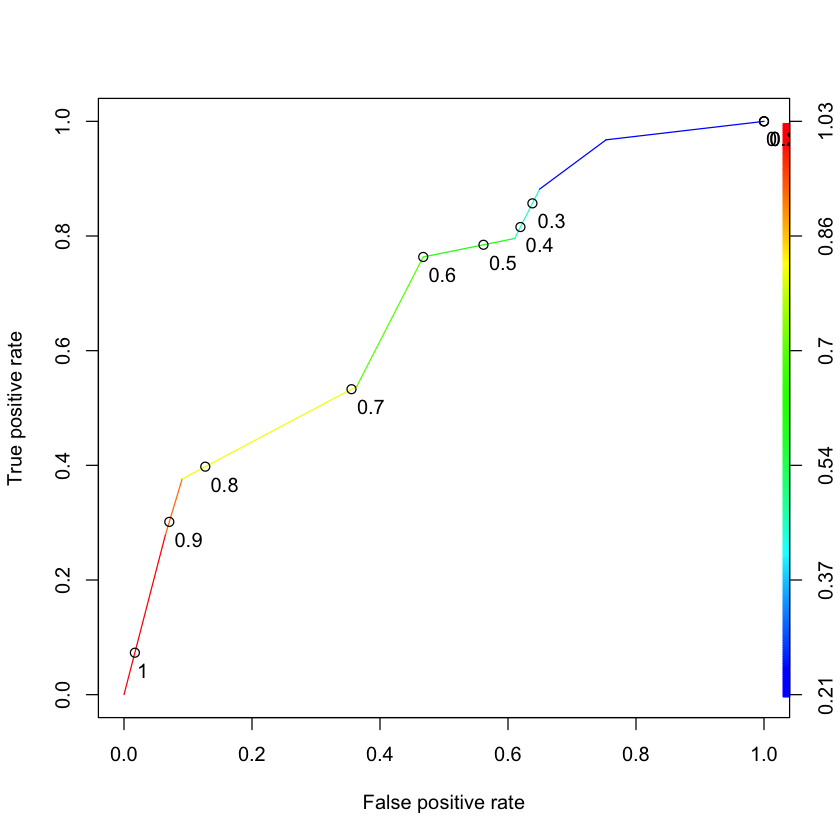

In [26]:
plot(perf,
     colorize=TRUE,
     print.cutoffs.at=seq(0, 1, 0.1),
     text.adj=c(-0.2,1.7))

In [27]:
as.numeric(performance(pred, "auc")@y.values)

[1] 0.6927105

## Play with minbucket

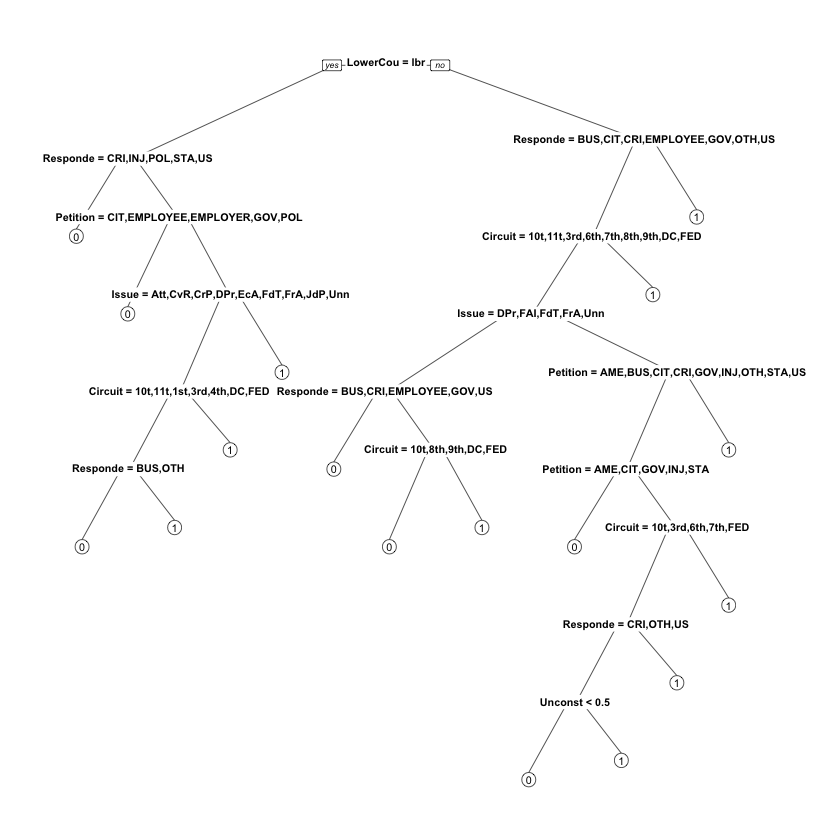

In [30]:
StevensTreeB5 = rpart(Reverse ~Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst,
                   data=Train, method='class', minbucket=5) # method='class' means classificaiton tree
prp(StevensTreeB5)

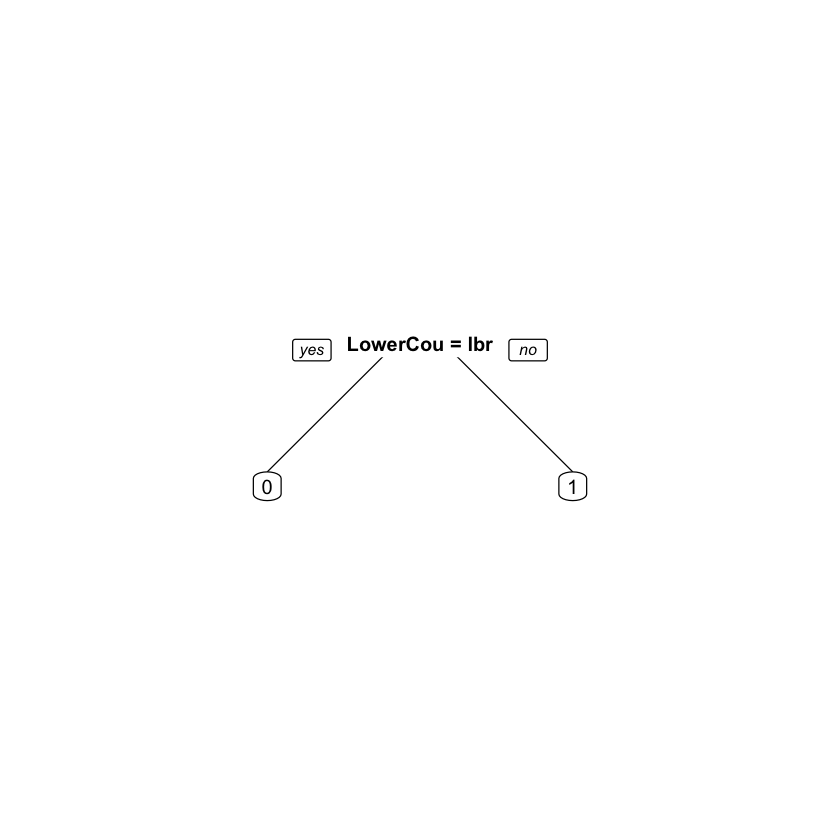

In [32]:
StevensTreeB100 = rpart(Reverse ~Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst,
                   data=Train, method='class', minbucket=100) # method='class' means classificaiton tree
prp(StevensTreeB100)


# Random Forests

* To make a prediction for a new observation, each tree "votes" on the outcome, and we pick the outcome that receives the majority of the votes
* Each tree is built from a "bagged"/"bootstrapped" sample of the data:
    * Select observation randomly with replacement
    * Example: original data: 1 2 3 4 5
    * New "data": 
        * 2, 4, 5 ,2 ,1 -> first tree
        * 3, 5, 1, 5, 2 -> second tree
* Parameters in R:
    * nodesize : minimum number of observations in a subset / (or minbuket from CART), and smaller nodesize may take longer running time
    * ntree: number of trees: a couple of hundred is okay

In [33]:
#install.packages('randomForest')

library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [34]:
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner 
                             + Respondent + LowerCourt + Unconst,
                            data=Train,
                            nodesize=25,
                            ntree=200)
# RF has no input to define class or regression (not like in CART where we add type='class'),
#so we need to change the response as a factor

Warning message:
In randomForest.default(m, y, ...): The response has five or fewer unique values.  Are you sure you want to do regression?

In [35]:
Train$Reverse = as.factor(Train$Reverse)
Test$Reverse = as.factor(Test$Reverse)

In [36]:
# now we can do the RF model:
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner 
                             + Respondent + LowerCourt + Unconst,
                            data=Train,
                            nodesize=25,
                            ntree=200)

In [37]:
PredictForest = predict(StevensForest, newdata = Test)

In [38]:
table(Test$Reverse, PredictForest)

   PredictForest
     0  1
  0 44 33
  1 18 75

In [39]:
# Acc:
(44+75) / (44+75+18+33)

[1] 0.7

Better than the CART perdiction

## Test the randomness in Random Forest

In [44]:
set.seed(100)
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner 
                             + Respondent + LowerCourt + Unconst,
                            data=Train,
                            nodesize=25,
                            ntree=200)
PredictForest = predict(StevensForest, newdata = Test)
t = table(Test$Reverse, PredictForest)
# ACC:
(t[1,1] + t[2,2]) / sum(t)

[1] 0.6882353

In [45]:
set.seed(200)
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner 
                             + Respondent + LowerCourt + Unconst,
                            data=Train,
                            nodesize=25,
                            ntree=200)
PredictForest = predict(StevensForest, newdata = Test)
t = table(Test$Reverse, PredictForest)
# ACC:
(t[1,1] + t[2,2]) / sum(t)

[1] 0.7058824

# Cross-Validation

In [47]:
# install.packages('caret')
# install.packages('e1071')
library(caret)
library(e1071)

In [48]:
numFolds = trainControl(method='cv', number=10)
cpGrid = expand.grid(.cp=seq(0.01, 0.5, 0.01))

In [51]:
train(Reverse ~ Circuit + Issue + Petitioner 
        + Respondent + LowerCourt + Unconst,
     data=Train,
     method='rpart',
     trControl=numFolds,
     tuneGrid=cpGrid)

CART 

396 samples
  8 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 357, 356, 357, 356, 356, 356, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa      
  0.01  0.6365385  0.252522710
  0.02  0.6337179  0.248281522
  0.03  0.6314103  0.251796733
  0.04  0.6314103  0.253786180
  0.05  0.6440385  0.282995035
  0.06  0.6440385  0.282995035
  0.07  0.6440385  0.282995035
  0.08  0.6440385  0.282995035
  0.09  0.6440385  0.282995035
  0.10  0.6440385  0.282995035
  0.11  0.6440385  0.282995035
  0.12  0.6440385  0.282995035
  0.13  0.6440385  0.282995035
  0.14  0.6440385  0.282995035
  0.15  0.6440385  0.282995035
  0.16  0.6440385  0.282995035
  0.17  0.6440385  0.282995035
  0.18  0.6440385  0.282995035
  0.19  0.6440385  0.282995035
  0.20  0.6085897  0.193703966
  0.21  0.5807692  0.121202966
  0.22  0.5605128  0.062732119
  0.23  0.5428846  0.003553299
  0.24  0.5428846  0.003553299
  0.2

In [50]:
?rpart.control

rpart.control {rpart},R Documentation
minsplit,the minimum number of observations that must exist in a node in order for a split to be attempted.
minbucket,"the minimum number of observations in any terminal <leaf> node. If only one of minbucket or minsplit is specified, the code either sets minsplit to minbucket*3 or minbucket to minsplit/3, as appropriate."
cp,"complexity parameter. Any split that does not decrease the overall lack of fit by a factor of cp is not attempted. For instance, with anova splitting, this means that the overall R-squared must increase by cp at each step. The main role of this parameter is to save computing time by pruning off splits that are obviously not worthwhile. Essentially,the user informs the program that any split which does not improve the fit by cp will likely be pruned off by cross-validation, and that hence the program need not pursue it."
maxcompete,"the number of competitor splits retained in the output. It is useful to know not just which split was chosen, but which variable came in second, third, etc."
maxsurrogate,"the number of surrogate splits retained in the output. If this is set to zero the compute time will be reduced, since approximately half of the computational time (other than setup) is used in the search for surrogate splits."
usesurrogate,"how to use surrogates in the splitting process. 0 means display only; an observation with a missing value for the primary split rule is not sent further down the tree. 1 means use surrogates, in order, to split subjects missing the primary variable; if all surrogates are missing the observation is not split. For value 2 ,if all surrogates are missing, then send the observation in the majority direction. A value of 0 corresponds to the action of tree, and 2 to the recommendations of Breiman et.al (1984)."
xval,number of cross-validations.
surrogatestyle,"controls the selection of a best surrogate. If set to 0 (default) the program uses the total number of correct classification for a potential surrogate variable, if set to 1 it uses the percent correct, calculated over the non-missing values of the surrogate. The first option more severely penalizes covariates with a large number of missing values."
maxdepth,"Set the maximum depth of any node of the final tree, with the root node counted as depth 0. Values greater than 30 rpart will give nonsense results on 32-bit machines."
...,mop up other arguments.


In [52]:
StevensTreeCV = rpart(Reverse ~ Circuit + Issue + Petitioner 
                             + Respondent + LowerCourt + Unconst,
                    data=Train,
                    method='class',
                     cp=0.19)

In [53]:
PredictCV = predict(StevensTreeCV, newdata=Test, type='class')

In [54]:
t = table(Test$Reverse, PredictCV)
# ACC:
(t[1,1] + t[2,2]) / sum(t)

[1] 0.7235294

### Awesome, good acc

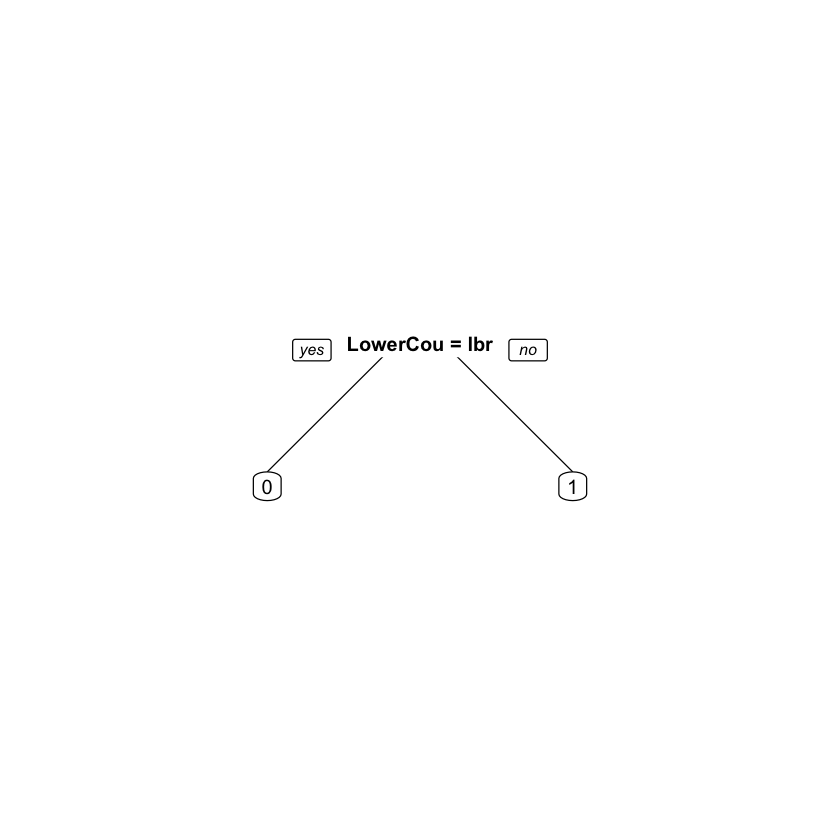

In [55]:
prp(StevensTreeCV)